# Бинарная классификация популярных и непопулярных онлайн новостей

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.model_selection, sklearn.linear_model, sklearn.svm, sklearn.metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score
import warnings
warnings.filterwarnings("ignore")

## 1. Предобработка данных

In [2]:
df = pd.read_csv('OnlineNewsPopularity.csv', sep = ',')

In [3]:
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [4]:
df.shape

(39644, 61)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             39644 non-null  object 
 1    timedelta                      39644 non-null  float64
 2    n_tokens_title                 39644 non-null  float64
 3    n_tokens_content               39644 non-null  float64
 4    n_unique_tokens                39644 non-null  float64
 5    n_non_stop_words               39644 non-null  float64
 6    n_non_stop_unique_tokens       39644 non-null  float64
 7    num_hrefs                      39644 non-null  float64
 8    num_self_hrefs                 39644 non-null  float64
 9    num_imgs                       39644 non-null  float64
 10   num_videos                     39644 non-null  float64
 11   average_token_length           39644 non-null  float64
 12   num_keywords                   

Пропусков данных нет, категориальный столбец - url

In [6]:
df.drop('url', axis = 1, inplace = True)

## 2. Выбор целевой переменной и задачи машинного обучения

Предполагается решение задачи бинарной классификации популярных и непопулярных онлайн новостей.

Целевой переменной было выбрано 'shares', которая была перекодирована в бинарном виде:
- если shares < 1400, то shares = 0, т. е. новость непопулярна
- если shares >= 1400, то shares = 1, т. е. новость популярна

In [7]:
for i in range(len(df[' shares'])):
    if (df[' shares'][i] < 1400):
        df[' shares'][i] = '0'
    else:
        df[' shares'][i] = '1'

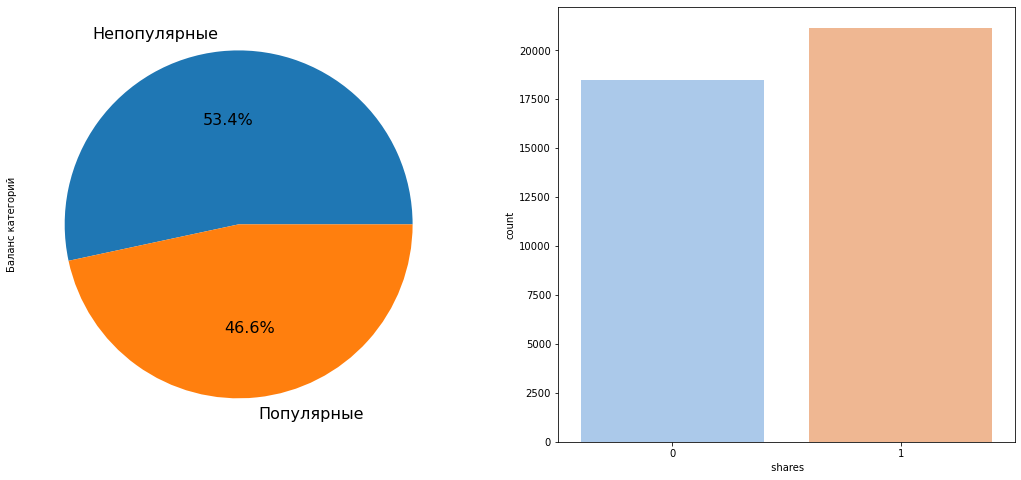

In [8]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
df[' shares'].value_counts().plot(kind="pie",
                                           fontsize=16,
                                           labels=['Непопулярные', 'Популярные'],
                                           ylabel="Баланс категорий",
                                           autopct='%1.1f%%');

plt.subplot(1, 2, 2)
sns.countplot(x=df[' shares'],data=df, palette="pastel")
plt.show()

Выделим целевую переменную:

In [9]:
X = df.drop(' shares', axis = 1)
y = df[' shares']
y = y.astype(int)

Нормализуем данные:

In [10]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

## 3. Решение задачи машинного обучения

Рассмотрим несколько моделей машинного обучения.

### 1. Logistic Regression

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 777)

In [12]:
%%time
logreg = LogisticRegression()
parameters = [{
    'penalty': ('l1','l2', 'elasticnet',None),
    'C': (100, 10, 1.0, 0.1, 0.01)
}]

grid_search = GridSearchCV(logreg, parameters)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 100, 'penalty': 'l2'}
0.6533263417872507
Wall time: 11.4 s


In [13]:
model_logreg = grid_search.best_estimator_
model_logreg.fit(X_train, y_train)
y_pred = (model_logreg.predict_proba(X_test)[:, 1] > 0.5).astype(int)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.61      0.62      6134
           1       0.67      0.70      0.68      6949

    accuracy                           0.66     13083
   macro avg       0.65      0.65      0.65     13083
weighted avg       0.66      0.66      0.66     13083



### 2. KNN

In [14]:
KNNModel = KNeighborsClassifier()
param_grid = dict(n_neighbors=list(range(1, 31)))
grid_search = GridSearchCV(KNNModel, param_grid, cv=5, scoring='accuracy', return_train_score=False, verbose=1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'n_neighbors': 29}
0.6336363877304814


In [15]:
KNNModel = grid_search.best_estimator_
KNNModel.fit(X_train, y_train)
y_pred = (KNNModel.predict_proba(X_test)[:, 1] > 0.4).astype(int)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.43      0.52      6134
           1       0.62      0.81      0.70      6949

    accuracy                           0.63     13083
   macro avg       0.64      0.62      0.61     13083
weighted avg       0.64      0.63      0.62     13083



### 3. Naive Bayes

In [16]:
naive = GaussianNB()
param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
grid_search = GridSearchCV(naive, param_grid, cv=5, scoring='accuracy', return_train_score=False, verbose=1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'var_smoothing': 0.0533669923120631}
0.5453868055508313


In [17]:
naive = grid_search.best_estimator_
naive.fit(X_train, y_train)
y_pred = (naive.predict_proba(X_test)[:, 1] > 0.5).astype(int)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.93      0.66      6134
           1       0.77      0.20      0.31      6949

    accuracy                           0.54     13083
   macro avg       0.64      0.57      0.49     13083
weighted avg       0.65      0.54      0.47     13083



### 4. Decision Tree

In [18]:
dtc = DecisionTreeClassifier()
param_grid = {
    'criterion':['gini','entropy'],
    'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50]
    }
grid_search = GridSearchCV(dtc, param_grid, cv=3, scoring='accuracy', return_train_score=False, verbose=1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
{'criterion': 'entropy', 'max_depth': 5}
0.6353297757745237


In [19]:
dtc = grid_search.best_estimator_
dtc.fit(X_train, y_train)
y_pred = (dtc.predict_proba(X_test)[:, 1] > 0.5).astype(int)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.57      0.60      6134
           1       0.65      0.71      0.68      6949

    accuracy                           0.65     13083
   macro avg       0.64      0.64      0.64     13083
weighted avg       0.64      0.65      0.64     13083



### 5. Random Forest

In [24]:
rfc = RandomForestClassifier()
param_grid = {
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
    }
grid_search = GridSearchCV(rfc, param_grid, cv=3, scoring='accuracy', return_train_score=False, verbose=1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 500}
0.6633034278315686


In [25]:
rfc = grid_search.best_estimator_
rfc.fit(X_train, y_train)
y_pred = (grid_search.predict_proba(X_test)[:, 1] > 0.5).astype(int)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.56      0.61      6134
           1       0.66      0.76      0.71      6949

    accuracy                           0.67     13083
   macro avg       0.67      0.66      0.66     13083
weighted avg       0.67      0.67      0.66     13083



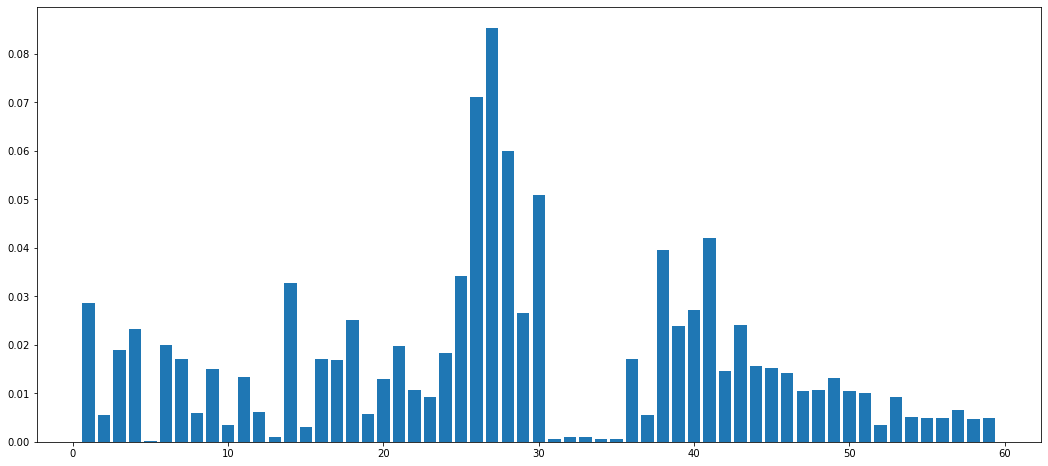

In [26]:
importance = rfc.feature_importances_
plt.figure(figsize=(18, 8))
plt.bar([x for x in range(1, 60)], importance)
plt.show()

In [38]:
arr = []
for i in range(len(importances)):
    if (importances[i] < 0.005):
        arr.append(i)

df_test = df.copy()

df_test = df_test.drop(df_test.columns[arr],axis = 1)

In [42]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0    timedelta                      39644 non-null  float64
 1    n_tokens_title                 39644 non-null  float64
 2    n_tokens_content               39644 non-null  float64
 3    n_unique_tokens                39644 non-null  float64
 4    n_non_stop_unique_tokens       39644 non-null  float64
 5    num_hrefs                      39644 non-null  float64
 6    num_self_hrefs                 39644 non-null  float64
 7    num_imgs                       39644 non-null  float64
 8    average_token_length           39644 non-null  float64
 9    num_keywords                   39644 non-null  float64
 10   data_channel_is_entertainment  39644 non-null  float64
 11   data_channel_is_socmed         39644 non-null  float64
 12   data_channel_is_tech           

### Сравнение моделей

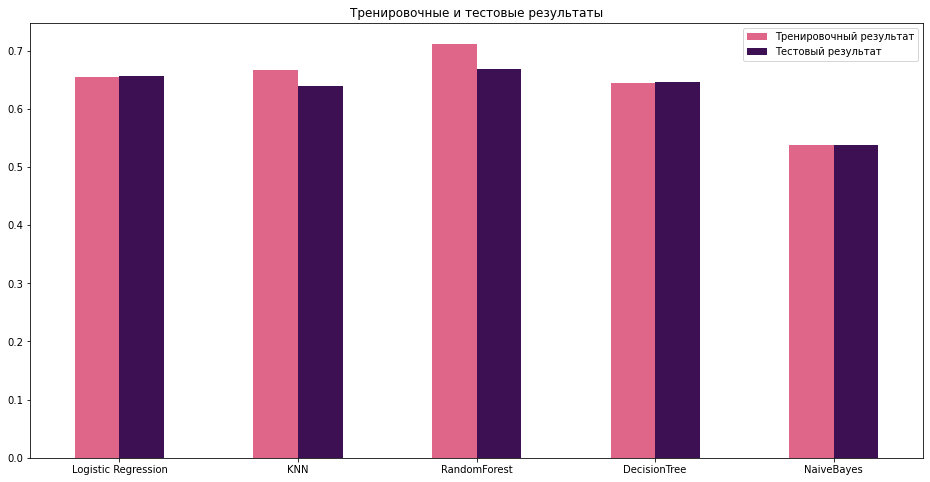

In [31]:
trainScores = [model_logreg.score(X_train, y_train), KNNModel.score(X_train, y_train), rfc.score(X_train, y_train), dtc.score(X_train, y_train), naive.score(X_train, y_train)]
testScores = [model_logreg.score(X_test, y_test), KNNModel.score(X_test, y_test), rfc.score(X_test, y_test), dtc.score(X_test, y_test), naive.score(X_train, y_train)]
indices = ['Logistic Regression', 'KNN', 'RandomForest', 'DecisionTree', 'NaiveBayes']
scores = pd.DataFrame({'Тренировочный результат': trainScores,'Тестовый результат': testScores}, index=indices)
plot = scores.plot.bar(figsize=(16, 8), rot=0, color=['#df6589ff', '#3c1053ff'])
plt.title('Тренировочные и тестовые результаты')
plt.show()

In [32]:
scores

,Тренировочный результат,Тестовый результат
Logistic Regression,0.655021,0.655966
KNN,0.666014,0.639914
RandomForest,0.712021,0.667890
DecisionTree,0.644366,0.645571
NaiveBayes,0.537630,0.537630


In [33]:
predRegression = model_logreg.predict(X_test)
predKNN = KNNModel.predict(X_test)
predRandomF = rfc.predict(X_test)
predDTree = dtc.predict(X_test)
predNaive = naive.predict(X_test)
predVals = pd.DataFrame(data={'truth': y_test, 'regression': predRegression, 'knn': predKNN, 'random-forest': predRandomF, 'decision-tree': predDTree, 'naive-bayes': predNaive})

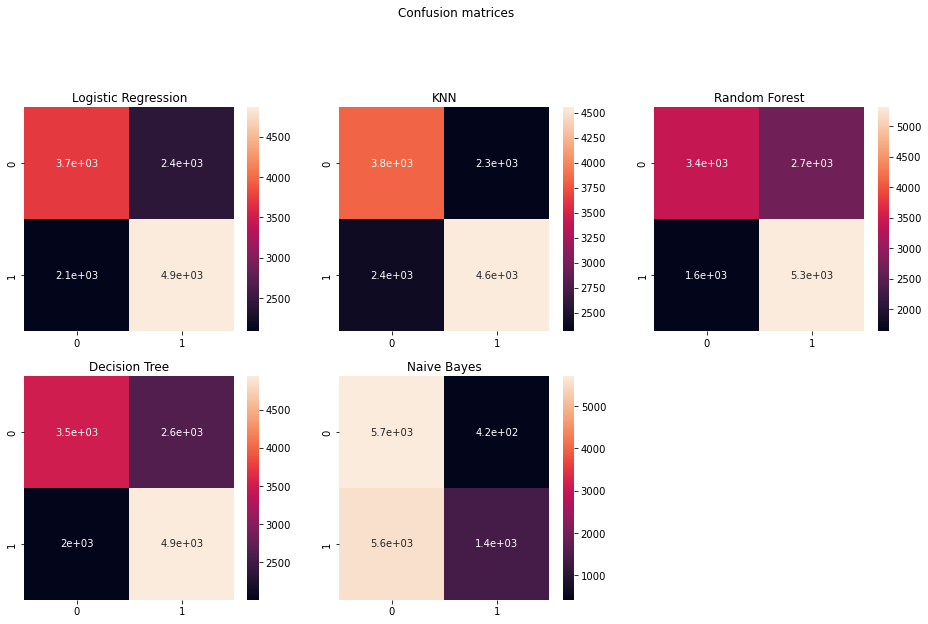

In [34]:
plt.figure(figsize=(16, 14))
plt.subplot(3, 3, 1)
sns.heatmap(sklearn.metrics.confusion_matrix(y_test, predRegression), annot=True).set(title='Logistic Regression')
plt.subplot(3, 3, 2)
sns.heatmap(sklearn.metrics.confusion_matrix(y_test, predKNN), annot=True).set(title='KNN')
plt.subplot(3, 3, 3)
sns.heatmap(sklearn.metrics.confusion_matrix(y_test, predRandomF), annot=True).set(title='Random Forest')
plt.subplot(3, 3, 4)
sns.heatmap(sklearn.metrics.confusion_matrix(y_test, predDTree), annot=True).set(title='Decision Tree')
plt.subplot(3, 3, 5)
sns.heatmap(sklearn.metrics.confusion_matrix(y_test, predNaive), annot=True).set(title='Naive Bayes')
plt.suptitle('Confusion matrices')
plt.show()

## 4. Анализ точности решения и необходимости доработки

In [ ]:
Полученное решение с помощью метода RandomForest можно попробовать доработать, 
убрав менее значимые параметры.

In [54]:
X = df_test.drop(' shares', axis = 1)
y = df_test[' shares']
y = y.astype(int)

In [44]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 777)

In [46]:
rfc = RandomForestClassifier()
param_grid = {
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
    }
grid_search = GridSearchCV(rfc, param_grid, cv=3, scoring='accuracy', return_train_score=False, verbose=1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 500}
0.6637551670210694


In [47]:
rfc = grid_search.best_estimator_
rfc.fit(X_train, y_train)
y_pred = (grid_search.predict_proba(X_test)[:, 1] > 0.5).astype(int)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.56      0.61      6134
           1       0.66      0.76      0.71      6949

    accuracy                           0.67     13083
   macro avg       0.67      0.66      0.66     13083
weighted avg       0.67      0.67      0.66     13083



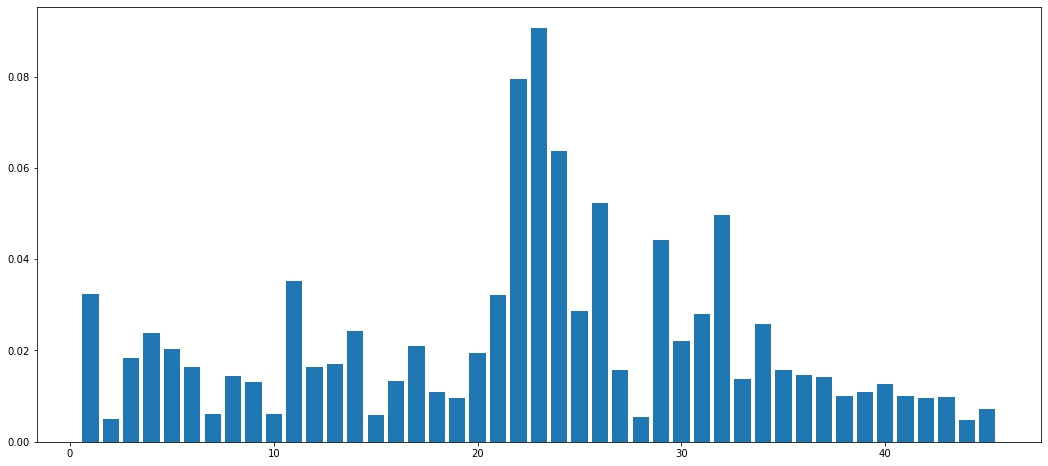

In [56]:
importance = rfc.feature_importances_
plt.figure(figsize=(18, 8))
plt.bar([x for x in range(1, 46)], importance)
plt.show()